### ROME

In [10]:
import xarray as xr

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import myPlots

In [2]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model

In [3]:
fileName = model + '_pr4_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [4]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 ...

In [5]:
fileName = model + '_pr_extreme_' + experiment + '.nc'
path = folder + '/' + fileName
ds_percentile = xr.open_dataset(path)

In [6]:
ds_percentile

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr_97    (time) float64 ...
    pr_99    (time) float64 ...
    pr_999   (time) float64 ...

In [7]:
historical = True
rcp85 = False

if historical:
    experiment = 'historical'
    period=slice('1970-01','1999-12')
    ensemble = 'r1i1p1'

    if model == 'GISS-E2-H':
        ensemble = 'r6i1p1'


if rcp85:
    experiment = 'rcp85'
    period=slice('2070-01','2099-12')

    if model == 'GISS-E2-H':
        ensemble = 'r2i1p1'

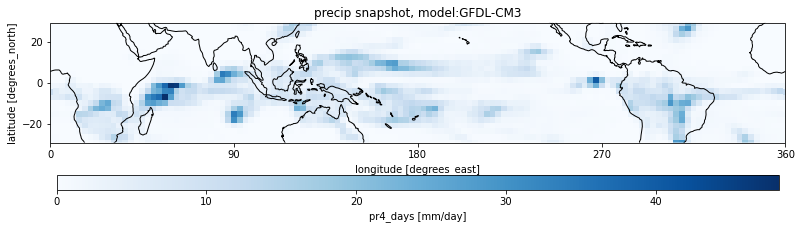

In [11]:
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

In [8]:
# Great circle distance (Haversine formula)
# takes vectorized inputs
def hav_dist(lat1, lon1, lat2, lon2):

   # radius of earth in km
   #R = 6373.0
        
    R = 6371

    lat1 = np.deg2rad(lat1)                       
    lon1 = np.deg2rad(lon1-180)     
    lat2 = np.deg2rad(lat2)                       
    lon2 = np.deg2rad(lon2-180)

    # Haversine formula
    h = np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2) * np.sin((lon2 - lon1)/2)**2

    # distance from Haversine function:
    # h = sin(theta/2)^2
    # central angle, theta:
    # theta = (great circle distance) / radius 
    # d = R * sin^-1(sqrt(h))*2 

    return 2 * R * np.arcsin(np.sqrt(h))

In [ ]:
# ROME
# calculated as: oA_area + min(1, oB/oD)*oB for each unique pair, and taking the mean of all pairs
# oA - larger of the pair of objects
# oD - the square of the shortest distance between object A and B

# Essentially it is the added areas unless the distance between the objects is larger than the smaller object
# in that case the contribution from the smaller area to the total is modulated

ROME_allPairs = []
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm = np.expand_dims(latm,axis=2)
lonm = np.expand_dims(lonm,axis=2)
sL = np.shape(L)

if len(labels) ==1:
    ROME_allPairs = np.sum((L==labels)*1 * aream)
    
else:
    for idx, labeli in enumerate(labels[0:-1]):

        # find coordinates of object i
        I, J = zip(*np.argwhere(L==labeli))
        I = list(I)
        J = list(J)

        # area of object i
        oi_area = np.sum(aream[I,J])

        # shortest distance from object i        
        # count the number of gridboxes
        Ni = len(I)

        # replicate each gridbox lon and lat to Ni 2D slices the shape of L
        lati3d = np.tile(lat[I],reps =[sL[0], sL[1], 1])
        loni3d = np.tile(lon[J],reps =[sL[0], sL[1], 1])

        # create corresponding 3D matrix from Ni copies of 
        # the mesh grid lon, lat, this metrix only needs to 
        # be recreated when Ni increases from previous loop
        if Ni > np.shape(lonm)[2]:
            lonm = np.tile(lonm[:,:,0:1],reps =[1, 1, Ni])
            latm = np.tile(latm[:,:,0:1],reps =[1, 1, Ni])
        # Otherwise you can index the previously created matrix to match lati3d, loni3d

        # distance from gridbox to every other point in the domain
        p_hav = hav_dist(lati3d,loni3d,latm[:,:,0:Ni],lonm[:,:,0:Ni])

        # minimum in the third dimension gives shortest distance from 
        # object i to every other point in the domain
        p_dist = np.amin(p_hav, axis=2)

        # pick out desired coordinates of p_dist, from the coordinates of the
        # unique pair object j
        # the minimum of the coordinates in p_dist will be the shortest distance.
        for labelj in labels[idx+1:]:
            # coordinates of object j
            I, J = zip(*np.argwhere(L==labelj))

            # area of object j
            oj_area = np.sum(aream[I,J])

            # ROME of unique pair
            large_area = np.maximum(oi_area, oj_area)
            small_area = np.maximum(oi_area, oj_area)
            ROME_pair = large_area + np.minimum(small_area, (small_area/np.amin(p_dist[I,J]))**2)
            ROME_allPairs = np.append(ROME_allPairs, ROME_pair)

In [ ]:
len(ROME_allPairs)

105

In [ ]:
ROME = np.mean(ROME_allPairs)

### ROME n largest

In [ ]:
# n largest objects (8)
# index of n largest objects in L
obj3d = np.stack([(L==label) for label in labels],axis=2)*1
lonm, latm = np.meshgrid(lon, lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

aream = np.expand_dims(aream,axis=2)


o_areaL = np.sum(obj3d * aream, axis=(0,1))
n = 8
if len(o_area) <= n:
    labels_n = labels
    L_n = L
else:
    labels_n = labels[o_areaL.argsort()[-n:]]
    L_n = np.sum(np.stack([(L==label) for label in labels_n],axis=2)*1, axis=2)


In [1]:
# plot n largest
O = pr_day.where(pr_day>=conv_threshold,0)>0
xr_Ln = xr.DataArray(L_n, coords={'lat': lat,'lon': lon})

projection = ccrs.PlateCarree(central_longitude=180)
f, (ax1, ax2) = plt.subplots(nrows = 2, subplot_kw=dict(projection=projection), figsize=(15, 7))

# objects binary
O.plot(ax=ax1, transform=ccrs.PlateCarree(), levels =4, colors = ['w','c','k'], add_colorbar=False) 
ax1.add_feature(cfeat.COASTLINE)
ax1.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax1.set_title('Snapshot of objects, model:' + model + ' exp:' + experiment)
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels([0, 90, 180, 270, 360])
ax1.set_yticks([-20, 0, 20])

# objects labeled
xr_Ln.plot(ax=ax2, transform=ccrs.PlateCarree(), levels =4, colors = ['w','c','deepskyblue'], add_colorbar=False) 
ax2.add_feature(cfeat.COASTLINE)
ax2.set_extent([lon[0], lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
ax2.set_xticks([-180, -90, 0, 90, 180])
ax2.set_xticklabels([0, 90, 180, 270, 360])
ax2.set_yticks([-20, 0, 20])

plt.tight_layout()

In [ ]:
# ROME for n largest
# calculated as: oA_area + min(1, oB/oD)*oB for each unique pair, and taking the mean of all pairs
# oA - larger of the pair of objects
# oD - the square of the shortest distance between object A and B

# Essentially it is the added areas unless the distance between the objects is larger than the smaller object
# in that case the contribution from the smaller area to the total is modulated

ROME_allPairs = []
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm = np.expand_dims(latm,axis=2)
lonm = np.expand_dims(lonm,axis=2)
sL = np.shape(L)

if len(labels_n) ==1:
    ROME_allPairs = np.sum((L==labels_n)*1 * aream)
    
else:
    for idx, labeli in enumerate(labels_n[0:-1]):

        # find coordinates of object i
        I, J = zip(*np.argwhere(L==labeli))
        I = list(I)
        J = list(J)

        # area of object i
        oi_area = np.sum(aream[I,J])

        # shortest distance from object i        
        # count the number of gridboxes
        Ni = len(I)

        # replicate each gridbox lon and lat to Ni 2D slices the shape of L
        lati3d = np.tile(lat[I],reps =[sL[0], sL[1], 1])
        loni3d = np.tile(lon[J],reps =[sL[0], sL[1], 1])

        # create corresponding 3D matrix from Ni copies of 
        # the mesh grid lon, lat, this metrix only needs to 
        # be recreated when Ni increases from previous loop
        if Ni > np.shape(lonm)[2]:
            lonm = np.tile(lonm[:,:,0:1],reps =[1, 1, Ni])
            latm = np.tile(latm[:,:,0:1],reps =[1, 1, Ni])
        # Otherwise you can index the previously created matrix to match lati3d, loni3d

        # distance from gridbox to every other point in the domain
        p_hav = hav_dist(lati3d,loni3d,latm[:,:,0:Ni],lonm[:,:,0:Ni])

        # minimum in the third dimension gives shortest distance from 
        # object i to every other point in the domain
        p_dist = np.amin(p_hav, axis=2)

        # pick out desired coordinates of p_dist, from the coordinates of the
        # unique pair object j
        # the minimum of the coordinates in p_dist will be the shortest distance.
        for labelj in labels_n[idx+1:]:
            # coordinates of object j
            I, J = zip(*np.argwhere(L==labelj))

            # area of object j
            oj_area = np.sum(aream[I,J])

            # ROME of unique pair
            large_area = np.maximum(oi_area, oj_area)
            small_area = np.maximum(oi_area, oj_area)
            ROME_pair = large_area + np.minimum(small_area, (small_area/np.amin(p_dist[I,J]))**2)
            ROME_allPairs = np.append(ROME_allPairs, ROME_pair)

In [ ]:
len(ROME_allPairs)

28

In [ ]:
ROME_n = np.mean(ROME_allPairs)

In [ ]:
# test with artificial fields
# artificial = xr.zeros_like(ds.pr4_days.isel(time=0))
# print(np.shape(artificial))
# artificial[1:5, -1] = 1
# #artificial[10:12, 10:25] = 1
# #artificial[10:12, 10:25] = 1
# myPlots.plot_snapshot(artificial, 'Blues', 'precip', model)